In [1]:
%cd /root/share/Real/KAIST/Production_management

%load_ext autoreload
%autoreload 2

/root/share/Real/KAIST/Production_management


In [2]:
import numpy as np
import pandas as pd
import scipy
import math

In [3]:
time_food_data = np.array([86, 70, 69, 77])

In [4]:
n_station = 7
mu_food_before = np.mean(time_food_data) / n_station
std_food_before =  math.sqrt(np.var(time_food_data)) / n_station
print(np.mean(time_food_data), math.sqrt(np.var(time_food_data)))

mu_food_after = 50 / n_station
std_food_after = 6.8 / n_station

n_people = 500

mu_cashier_before = 12
std_cashier_before = 3


mu_cashier_after= 6 #cahsier가 2배 늘어났으면 이 값을 2배 줄여주세요.
std_cashier_after = 3

75.5 6.800735254367722


In [5]:
time_food_before = scipy.stats.norm.rvs(size=n_people, loc=mu_food_before, scale=std_food_before)
time_food_after = scipy.stats.norm.rvs(size=n_people, loc=mu_food_after, scale=std_food_after)

#scale = 1/beta = (alpha/beta^2)/(alpha/beta) = variance / mu
#alpha = mu / scale
time_food_before = scipy.stats.gamma.rvs(size=n_people, a =mu_food_before/((std_food_before)**2/mu_food_before), scale=(std_food_before)**2/mu_food_before)
time_food_after = scipy.stats.gamma.rvs(size=n_people, a =mu_food_after/((std_food_after)**2/mu_food_after), scale=(std_food_after)**2/mu_food_after)

time_cashier_before = scipy.stats.gamma.rvs(size=n_people, a =mu_cashier_before/((std_cashier_before)**2/mu_cashier_before), scale=(std_cashier_before)**2/mu_cashier_before)
time_cashier_after = scipy.stats.gamma.rvs(size=n_people, a =mu_cashier_after/((std_cashier_after)**2/mu_cashier_after), scale=(std_cashier_after)**2/mu_cashier_after)

In [6]:
def calculation_spent_time_to_enter(time_food):
    spent_time_to_enter_list = []

    #앞사람
    spent_time_to_enter_list.append(0)
    for num in range(1, n_station):
        spent_time_to_enter = np.max(time_food[0:num])
        spent_time_to_enter_list.append(spent_time_to_enter)

    #뒷사람
    for num in range(0, n_people-n_station):
        spent_time_to_enter = np.max(time_food[num:num+n_station])
        spent_time_to_enter_list.append(spent_time_to_enter)

    return spent_time_to_enter_list

def calculation_spent_time_to_get_food(time_food):
    spent_time_to_get_food_list = []

    #앞사람
    spent_time_to_get_food_list.append(n_station * time_food[0])
    for num in range(1, n_station):
        spent_time_to_get_food = (n_station - num) * time_food[num] + sum([np.max(time_food[num-station: num+1]) for station in range(num)])
        spent_time_to_get_food_list.append(spent_time_to_get_food)

    #뒷사람
    for num in range(n_station, n_people):
        spent_time_to_get_food = sum([np.max(time_food[num-station: num+1]) for station in range(n_station)])
        spent_time_to_get_food_list.append(spent_time_to_get_food)

    return spent_time_to_get_food_list

def calculation_spent_time_to_cashier(time_food, time_cashier):
    spent_time_to_cashier_list = []
    spent_time_to_cashier_list.append(time_cashier[0])

    for num in range(1, n_people):
        total_wating = sum(time_cashier[0:num])
        time_passed = sum(time_food[1:num+1]) 

        spent_time_to_cashier = max(0, total_wating-time_passed) + time_cashier[num]
        spent_time_to_cashier_list.append(spent_time_to_cashier)

    return spent_time_to_cashier_list

In [7]:
#줄이 줄어드는 시간! -> sum(list[0:num])은 num번째 사람이 들어갈 때까지 기다려야 했던 시간
spent_time_to_enter_before_list = np.array(calculation_spent_time_to_enter(time_food_before))
spent_time_to_enter_after_list = np.array(calculation_spent_time_to_enter(time_food_after))

#n번째 사람이 들어갈 때까지 걸린 시간
cumul_spent_time_to_enter_before_list = np.cumsum(spent_time_to_enter_before_list)
cumul_spent_time_to_enter_after_list =  np.cumsum(spent_time_to_enter_after_list)

#음식을 받는 데 걸린 시간 -> list[num]은 (num+1)번째 사람이 입장 이후 음식을 받는 데 걸린 시간
spent_time_to_get_food_before_list = np.array(calculation_spent_time_to_get_food(time_food_before))
spent_time_to_get_food_after_list = np.array(calculation_spent_time_to_get_food(time_food_after))

#캐셔에서 걸린 시간 -> list[num]은 대기 시간 + 내 시간
spent_time_to_cashier_before = np.array(calculation_spent_time_to_cashier(time_food_before, time_cashier_before))
spent_time_to_cashier_after = np.array(calculation_spent_time_to_cashier(time_food_after, time_cashier_after))

In [10]:
#total time: 줄 대기부터 결제까지 걸린 시간
#flow time: 일단 줄을 다 서고, 음식을 받기 시작~결제 시간
#cycle time: 다소 정의하기 애매한데, 일단 (n+1)번째 사람 결제 완료 시간 - n번째 사람 결제 완료 시간

total_time_before = cumul_spent_time_to_enter_before_list + spent_time_to_get_food_before_list + spent_time_to_cashier_before
total_time_after= cumul_spent_time_to_enter_after_list + spent_time_to_get_food_after_list + spent_time_to_cashier_after

flow_time_before = spent_time_to_get_food_before_list + spent_time_to_cashier_before
flow_time_after= spent_time_to_get_food_after_list + spent_time_to_cashier_after

cycle_time_before = np.diff(total_time_before)
cycle_time_after = np.diff(total_time_after)

In [11]:
#평균 cycle time
print(np.mean(cycle_time_before), np.mean(cycle_time_after))

12.971781585918011 8.462676651875341


In [12]:
#time limit (second) 내에 몇 명을 받을 수 있을까?
time_limit = 3600 

capacity_before = len(total_time_before[(total_time_before < 3600)])
capacity_after = len(total_time_before[(total_time_after < 3600)])

print(capacity_before, capacity_after)

267 425


In [13]:
#n명이 앞에 있을 때 얼마나 기다려야 밥을 먹을 수 있을까? (estimation)
n = 100
print(total_time_before[n], total_time_after[n])

1375.725497582136 891.1784690104984


In [14]:
#학생들이 할애 가능한 대기 시간 분포 (simulation)

n_simul = 100000
prop_after_class = 0.8 #다음 수업 가야하는 사람 비율

after_class = scipy.stats.bernoulli.rvs(prop_after_class, size=n_simul)
dist_after_class = scipy.stats.gamma.rvs(a = 15, scale = 1, size=n_simul)
dist_before_class = scipy.stats.gamma.rvs(a = 60, scale = 0.33, size=n_simul)

dist = np.concatenate((dist_before_class[np.invert(after_class.astype('bool'))], dist_after_class[after_class.astype('bool')])) 

In [15]:
#n명이 앞에 있을 때 기다릴 수 있는 비율 (simulation)

n = 100
print(np.sum(dist*60 > total_time_before[n])/n_simul, np.sum(dist*60 > total_time_after[n])/n_simul)

0.04949 0.58308


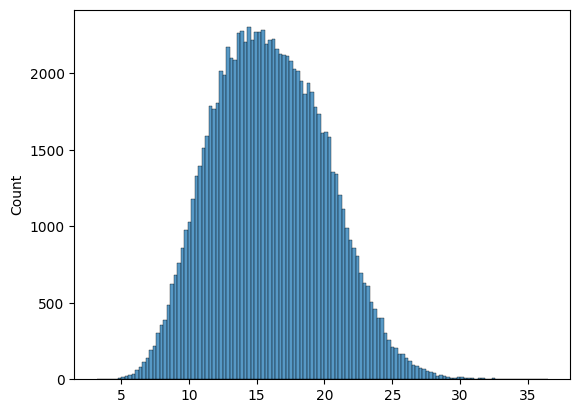

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(dist)
plt.show()

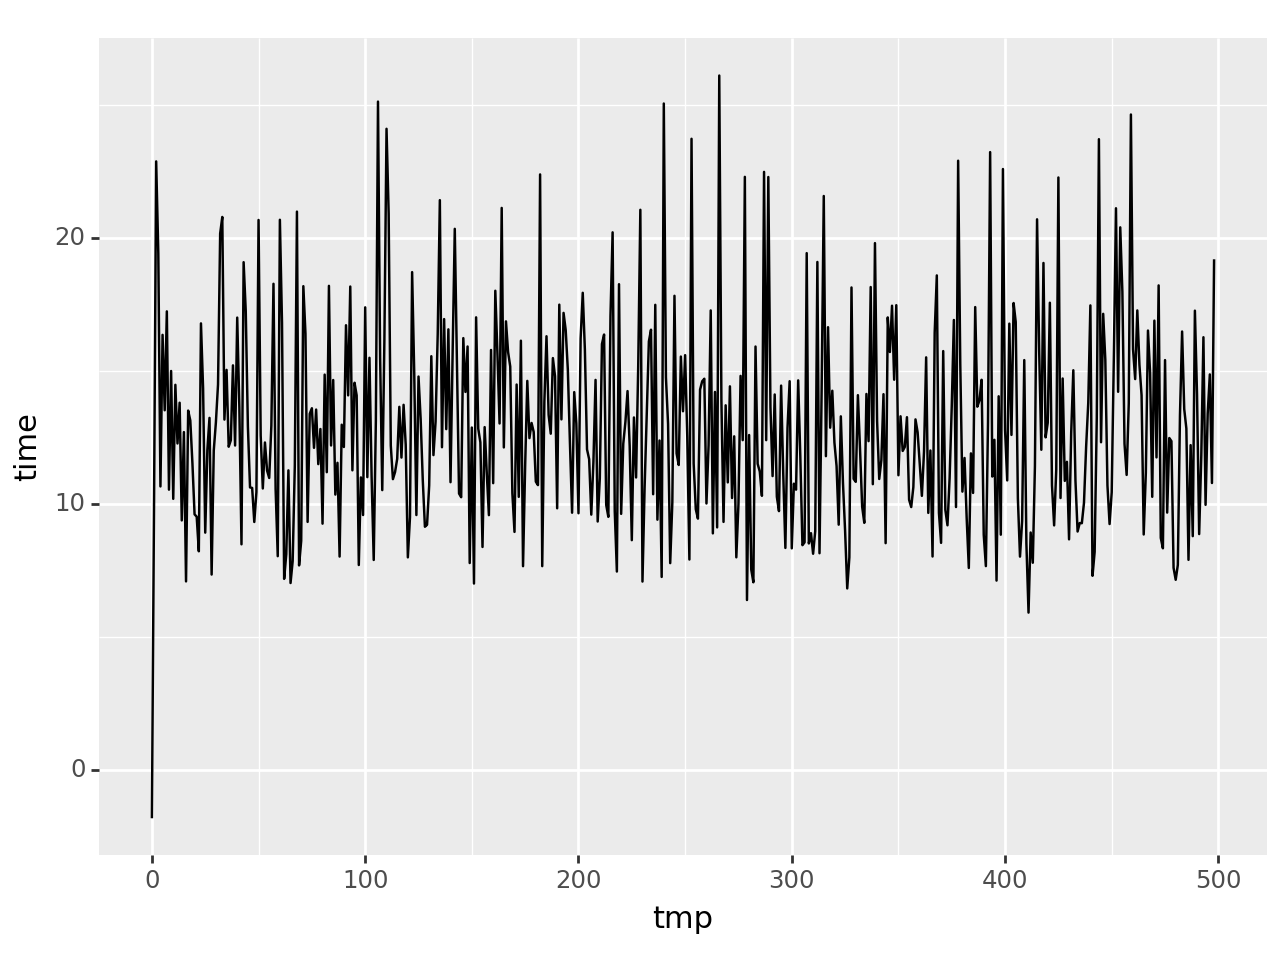

<Figure Size: (640 x 480)>

In [17]:
import plotnine as p9

df = pd.DataFrame(cycle_time_before, columns=['time'])
df['tmp'] = df.index
p9.ggplot(df, p9.aes(x='tmp', y='time')) + p9.geom_line()